In [116]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint 
from statsmodels.regression.rolling import RollingOLS

import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

import datetime as dt
import time

In [ ]:
# data downloading and reading
"""
XLK ETF top 23 components (Technology, 'APP' 'PLTR' removed due to low historical data): 
['NVDA', 'AAPL', 'MSFT', 'AVGO', , 'AMD', 'CSCO', 'ORCL', 'IBM', 'MU',
               'CRM', 'AMAT', 'LRCX', 'QCOM', 'INTU', 'APH', 'NOW', 'INTC', 'ACN',
               'KLAC', 'TXN', 'ADBE', 'ANET', 'ADI']

XLRE ETF top 30 components (Real Estate):
['WELL', 'PLD', 'AMT', 'EQIX', 'SPG', 'CBRE', 'O', 'PSA', 'DLR', 'CCI',
               'VTR', 'VICI', 'CSGP', 'EXR', 'AVB', 'IRM', 'EQR', 'SBAC', 'ESS', 'WY',
               'MAA', 'INVH', 'KIM', 'DOC', 'REG', 'CPT', 'HST', 'UDR', 'BXP', 'ARE']

XLP ETF top 29 components (Consumer Staples, 'KVUE' removed due to low historical data):
['WMT', 'COST', 'PG', 'KO', 'PM', 'PEP', 'CL', 'MDLZ', 'MO', 'MNST',
               'TGT', 'KR', 'KDP', 'SYY', 'KMB', 'ADM', 'HSY', 'GIS', 'DG',
               'EL', 'K', 'KHC', 'DLTR', 'CHD', 'STZ', 'MKC', 'TSN', 'BG', 'CLX']

XLI ETF top 29 components (Industrial, 'GEV' removed due to low historical data):
['GE', 'CAT', 'RTX', 'UBER', 'BA', 'UNP', 'ETN', 'HON', 'DE',
               'PH', 'ADP', 'TT', 'MMM', 'LMT', 'GD', 'HWM', 'WM', 'TDG', 'JCI',
               'EMR', 'NOC', 'UPS', 'CMI', 'PWR', 'ITW', 'NSC', 'CSX', 'CTAS', 'FDX']

Common tickers:
['NVDA', 'AAPL', 'MSFT', 'META', 'AMZN', 'GOOGL', 'TSLA', 'V', 'WMT', 'RACE', 'PFE', 'BABA', 
'NFLX', 'MC.PA', 'ZM', 'T', 'BAC', 'ALV.DE', 'IBE1.F', 'VOW3.DE', 'DBK.DE', 'BAYN.DE', 'AF.PA']

"""
# Symbols to download
symbol_list = ['NVDA', 'AAPL', 'MSFT', 'META', 'AMZN', 'GOOGL', 'TSLA', 'V', 'WMT', 'RACE', 'PFE', 'BABA', 
                'NFLX', 'MC.PA', 'ZM', 'T', 'BAC', 'ALV.DE', 'IBE1.F', 'VOW3.DE', 'DBK.DE', 'BAYN.DE', 'AF.PA']

# # set the dates range
# start_date = '2020-01-01'
# end_date = dt.datetime.now().strftime('%Y-%m-%d')

# # download data
# # data = yf.download(symbol_list, period="max", group_by='ticker', auto_adjust=True)
# data = yf.download(symbol_list, start=start_date, end=end_date, group_by='ticker', auto_adjust=True)

# # download data to csv
# data.to_csv(f"{'_'.join(symbol_list)}_D_data.csv")

# Load the CSV with MultiIndex columns (Tickers, OHLCV)
data = pd.read_csv(f"{'_'.join(symbol_list)}_D_data.csv", header=[0,1], index_col=0)

# Drop any rows that are completely NaN (e.g. 'Date' row)
data = data.dropna(how='all')

# Convert all values to float
data = data.astype(float)

# Show the result
data.head()

Ticker            EXR                                                    EQR  \
Price            Open       High        Low      Close     Volume       Open   
Date                                                                           
2020-01-02  85.436473  85.476821  84.105063  84.508522   950900.0  65.209403   
2020-01-03  84.387487  86.009388  84.242242  85.952904   745000.0  63.709883   
2020-01-06  85.944804  86.356328  85.299268  85.896385  1207800.0  64.664140   
2020-01-07  85.444532  85.743094  84.936176  85.509087   893600.0  64.038681   
2020-01-08  85.525211  85.864122  84.847404  85.678528   791200.0  64.086780   

Ticker                                                  ...       CSGP  \
Price            High        Low      Close     Volume  ...       Open   
Date                                                    ...              
2020-01-02  65.337708  63.629686  63.966476  1797800.0  ...  60.504002   
2020-01-03  64.888657  63.677813  64.792435  1326500.0  ...  61.542000   
2020-01-06  65.313666  64.287252  64.976875  1764300.0  ...  62.344002   
2020-01-07  64.840568  63.758022  64.014626  1194800.0  ...  62.564999   
2020-01-08  64.511779  63.862253  64.150932  2388900.0  ...  62.131001   

Ticker                                                        CPT             \
Price            High        Low      Close     Volume       Open       High   
Date                                                                           
2020-01-02  62.112999  60.354000  62.066002  3162000.0  87.804388  87.804388   
2020-01-03  62.678001  61.362000  62.619999  2096000.0  86.231903  87.425684   
2020-01-06  62.563000  61.603001  62.450001  1880000.0  87.310405  87.870245   
2020-01-07  62.736000  61.831001  62.002998  2330000.0  87.203386  87.359814   
2020-01-08  62.865002  61.869999  62.537998  2305000.0  86.487112  86.981088   

Ticker                                      
Price             Low      Close    Volume  
Date                                        
2020-01-02  86.190731  86.495346  585600.0  
2020-01-03  86.050777  87.186928  473800.0  
2020-01-06  86.758792  87.598557  835100.0  
2020-01-07  86.380091  86.520050  556000.0  
2020-01-08  86.166028  86.701164  614200.0  

[5 rows x 150 columns]

In [118]:
# Print data length and date range before dropping NaNs
print(f"Initial data shape: {data.shape}")
print(f"Date range: {data.index.min()} to {data.index.max()}")

# Remove rows where all values are NaN
data = data.dropna(how='all')

# For pairs trading, we typically only need Close prices
# Extract Close prices for both tickers
close_prices = data.xs('Close', level=1, axis=1)

# Clean ticker names if needed (remove any suffixes, for forex scenario)
close_prices.columns = close_prices.columns.str.replace('=X', '', regex=False)

# Drop any remaining NaN values
close_prices = close_prices.dropna()

# Print data length and date range after dropping NaNs
print(f"Data shape after dropping all-NaN rows: {close_prices.shape}")
print(f"Date range: {close_prices.index.min()} to {close_prices.index.max()}")

print("Cleaned close prices data:")
print(close_prices.head())
print(f"\nData shape: {close_prices.shape}")
print(f"Date range: {close_prices.index.min()} to {close_prices.index.max()}")

# Use close_prices for the pairs trading analysis
data = close_prices

Initial data shape: (1493, 150)
Date range: 2020-01-02 to 2025-12-09
Data shape after dropping all-NaN rows: (1493, 30)
Date range: 2020-01-02 to 2025-12-09
Cleaned close prices data:
Ticker            EXR        EQR         ESS        DLR        REG          O  \
Date                                                                            
2020-01-02  84.508522  63.966476  243.430099  96.832558  48.440357  52.380985   
2020-01-03  85.952904  64.792435  245.813141  98.424561  49.013660  53.327709   
2020-01-06  85.896385  64.976875  244.833817  97.538292  49.139317  53.595112   
2020-01-07  85.509087  64.014626  241.838684  96.578171  48.440357  53.609539   
2020-01-08  85.678528  64.150932  243.234253  97.415192  48.833035  53.855267   

Ticker             AVB         PSA       INVH         CCI  ...        SBAC  \
Date                                                       ...               
2020-01-02  169.673294  165.945862  25.023125  110.266434  ...  221.285370   
2020-01-03  17

In [119]:
# # manual filter to keep Date >= '2014-01-01'
# data = data[data.index >= '2014-01-01']

# # manual filter to exclude Date >= '2024-01-01'
# data = data[data.index < '2024-01-01']

In [120]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [121]:
# Time Series Split for Pairs Trading
# For financial time series, we use temporal split instead of random split
# This preserves the time order and avoids look-ahead bias
def temporal_split(data, train_ratio=0.7):
    """
    Split time series data temporally (chronologically)
    
    Parameters:
    data: DataFrame with time series data
    train_ratio: proportion of data to use for training (default 70%)
    
    Returns:
    train_data: DataFrame with training period data
    test_data: DataFrame with testing period data
    split_date: the date where split occurs
    """
    n_train = int(len(data) * train_ratio)
    train_data = data.iloc[:n_train]
    test_data = data.iloc[n_train:]
    split_date = data.index[n_train-1] if n_train > 0 else data.index[0]
    
    print(f"Total observations: {len(data)}")
    print(f"Training period: {data.index[0]} to {split_date} ({len(train_data)} observations)")
    print(f"Testing period: {data.index[n_train]} to {data.index[-1]} ({len(test_data)} observations)")
    print(f"Train ratio: {len(train_data)/len(data):.1%}")
    
    return train_data, test_data, split_date

# Split the data temporally
train_data, test_data, split_date = temporal_split(data, train_ratio=0.7)

Total observations: 1493
Training period: 2020-01-02 to 2024-02-27 (1045 observations)
Testing period: 2024-02-28 to 2025-12-09 (448 observations)
Train ratio: 70.0%


In [122]:
# Step 1: Find cointegrated pairs using TRAINING data only
# This prevents look-ahead bias in the strategy
scores_train, pvalues_train, pairs_train = find_cointegrated_pairs(train_data)

print("=== TRAINING PERIOD COINTEGRATION ANALYSIS ===")
print(f"Analysis period: {train_data.index[0]} to {train_data.index[-1]}")
print(f"Number of observations: {len(train_data)}")

=== TRAINING PERIOD COINTEGRATION ANALYSIS ===
Analysis period: 2020-01-02 to 2024-02-27
Number of observations: 1045


In [123]:
# Step 2: Validate cointegration on TEST data
# Check if pairs found in training period maintain cointegration in test period
scores_test, pvalues_test, pairs_test = find_cointegrated_pairs(test_data)

print("\n=== TESTING PERIOD COINTEGRATION VALIDATION ===")
print(f"Analysis period: {test_data.index[0]} to {test_data.index[-1]}")
print(f"Number of observations: {len(test_data)}")


=== TESTING PERIOD COINTEGRATION VALIDATION ===
Analysis period: 2024-02-28 to 2025-12-09
Number of observations: 448


In [124]:
# Function to validate pairs consistency
def validate_pairs_consistency(pairs_train, pairs_test, pvalues_train, pvalues_test, data_train, data_test):
    """
    Validate if pairs found in training maintain cointegration in testing
    """
    print(f"\nPairs found in training: {len(pairs_train)}")
    print(f"Pairs found in testing: {len(pairs_test)}")

    # print names of pairs found in training
    print("\nPairs found in training period:")
    for pair in pairs_train:
        print(f"- {pair[0]} / {pair[1]}")   

    # print names of pairs found in testing
    print("\nPairs found in testing period:")
    for pair in pairs_test:
        print(f"- {pair[0]} / {pair[1]}")
    
    # Handle case when no training pairs exist
    if len(pairs_train) == 0:
        print("No pairs found in training period - cannot validate consistency")
        print("Consider:")
        print("- Relaxing cointegration threshold (e.g., p < 0.1)")
        print("- Using longer training period")
        print("- Checking data quality")
        
        # Show best pairs from training period anyway
        if len(pvalues_train) > 0:
            symbols = list(data_train.columns)
            n = len(symbols)
            
            best_train_pairs = []
            for i in range(n):
                for j in range(i+1, n):
                    best_train_pairs.append({
                        'pair': f"{symbols[i]}/{symbols[j]}",
                        'train_pvalue': pvalues_train[i, j],
                        'significant': pvalues_train[i, j] < 0.05
                    })
            
            best_train_df = pd.DataFrame(best_train_pairs)
            best_train_df = best_train_df.sort_values('train_pvalue')
            
            print(f"\nBest pairs from training (sorted by p-value):")
            print(best_train_df.head(5))
        
        return [], pd.DataFrame()
    
    # Check which training pairs are also significant in testing
    consistent_pairs = []
    validation_results = []
    
    for pair in pairs_train:
        symbol1, symbol2 = pair
        
        # Find indices for this pair in training data
        train_cols = list(data_train.columns)
        i_train = train_cols.index(symbol1)
        j_train = train_cols.index(symbol2)
        
        # Ensure upper triangular access (i < j)
        if i_train > j_train:
            i_train, j_train = j_train, i_train
        
        train_pvalue = pvalues_train[i_train, j_train]
        
        # Find indices for this pair in testing data  
        test_cols = list(data_test.columns)
        i_test = test_cols.index(symbol1)
        j_test = test_cols.index(symbol2)
        
        # Ensure upper triangular access (i < j)
        if i_test > j_test:
            i_test, j_test = j_test, i_test
        
        test_pvalue = pvalues_test[i_test, j_test]
        
        # Check if still cointegrated in test period
        is_consistent = test_pvalue < 0.05
        
        validation_results.append({
            'pair': f"{symbol1}/{symbol2}",
            'train_pvalue': train_pvalue,
            'test_pvalue': test_pvalue,
            'consistent': is_consistent,
            'pvalue_change': test_pvalue - train_pvalue
        })
        
        if is_consistent:
            consistent_pairs.append(pair)
    
    # Create validation DataFrame
    validation_df = pd.DataFrame(validation_results)
    if len(validation_df) > 0:
        validation_df = validation_df.sort_values('test_pvalue')
    
    print(f"Consistent pairs (significant in both periods): {len(consistent_pairs)}")
    if len(pairs_train) > 0:
        print(f"Consistency rate: {len(consistent_pairs)/len(pairs_train):.1%}")
    
    return consistent_pairs, validation_df

# Validate pairs consistency
consistent_pairs, validation_df = validate_pairs_consistency(
    pairs_train, pairs_test, pvalues_train, pvalues_test, train_data, test_data
)

if len(validation_df) > 0:
    print(f"\n=== PAIRS VALIDATION RESULTS ===")
    print(validation_df)
else:
    print(f"\n=== NO VALIDATION POSSIBLE ===")
    print("No cointegrated pairs found in training period")

if len(consistent_pairs) > 0:
    print("\nConsistent pairs across training and testing periods:")
    for pair in consistent_pairs:
        print(f"- {pair[0]} / {pair[1]}")


Pairs found in training: 33
Pairs found in testing: 17

Pairs found in training period:
- EXR / O
- EQR / UDR
- EQR / MAA
- EQR / CPT
- REG / PSA
- O / PSA
- O / INVH
- O / UDR
- O / PLD
- O / CBRE
- O / MAA
- O / CPT
- PSA / HST
- PSA / KIM
- INVH / PLD
- INVH / CBRE
- CCI / DOC
- UDR / CPT
- VTR / PLD
- VTR / CBRE
- VTR / MAA
- VTR / WY
- VTR / CPT
- DOC / ARE
- DOC / SBAC
- HST / WELL
- HST / IRM
- HST / SPG
- HST / KIM
- HST / VICI
- PLD / CBRE
- PLD / SPG
- AMT / BXP

Pairs found in testing period:
- EQR / AVB
- EQR / PSA
- EQR / UDR
- EQR / EQIX
- ESS / PSA
- ESS / HST
- ESS / EQIX
- ESS / MAA
- ESS / SBAC
- ESS / CPT
- AVB / EQIX
- PSA / IRM
- INVH / SPG
- CCI / AMT
- UDR / EQIX
- HST / MAA
- IRM / BXP
Consistent pairs (significant in both periods): 1
Consistency rate: 3.0%

=== PAIRS VALIDATION RESULTS ===
         pair  train_pvalue  test_pvalue  consistent  pvalue_change
1     EQR/UDR      0.042935     0.017083        True      -0.025852
3     EQR/CPT      0.025677     0.062

In [125]:
# # To fix later

# # Visualize cointegration results - Training vs Testing period
# fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# # Training period heatmap
# sns.heatmap(
#     pvalues_train, 
#     xticklabels=symbol_list, 
#     yticklabels=symbol_list, 
#     cmap='RdYlGn_r',  # Red = high p-value (bad), Green = low p-value (good)
#     vmin=0, 
#     vmax=0.1,  # Focus on the significant range
#     ax=axes[0],
#     annot=True,
#     fmt='.3f',
#     cbar_kws={'label': 'P-Value'}
# )
# axes[0].set_title('Training Period - Cointegration P-Values\n(Lower = Better, p < 0.05 is significant)', fontsize=14)

# # Testing period heatmap
# sns.heatmap(
#     pvalues_test, 
#     xticklabels=symbol_list, 
#     yticklabels=symbol_list, 
#     cmap='RdYlGn_r',
#     vmin=0, 
#     vmax=0.1,
#     ax=axes[1],
#     annot=True,
#     fmt='.3f',
#     cbar_kws={'label': 'P-Value'}
# )
# axes[1].set_title('Testing Period - Cointegration P-Values\n(Lower = Better, p < 0.05 is significant)', fontsize=14)

# plt.tight_layout()
# plt.show()

In [126]:
# Enhanced Backtesting Framework
# Use parameters estimated from training period and test on out-of-sample data
def estimate_hedge_ratio_and_spread(data, symbol1, symbol2):
    """
    Estimate hedge ratio and calculate spread for a pair
    Returns regression results and spread series
    """
    S1 = data[symbol1]
    S2 = data[symbol2]
    
    # Add constant for regression
    S1_const = sm.add_constant(S1)
    results = sm.OLS(S2, S1_const).fit()
    
    # Get regression coefficient (hedge ratio)
    hedge_ratio = results.params[symbol1]
    intercept = results.params['const']
    
    # Calculate spread
    spread = S2 - hedge_ratio * S1
    
    return {
        'hedge_ratio': hedge_ratio,
        'intercept': intercept,
        'results': results,
        'spread': spread,
        'spread_mean': spread.mean(),
        'spread_std': spread.std()
    }

def backtest_pair_strategy(train_data, test_data, symbol1, symbol2, z_threshold=1.0):
    """
    Backtest a pairs trading strategy:
    1. Estimate parameters on training data
    2. Apply strategy on test data with those parameters
    """
    print(f"\n=== BACKTESTING {symbol1}/{symbol2} ===")
    
    # Step 1: Estimate parameters on training data
    train_params = estimate_hedge_ratio_and_spread(train_data, symbol1, symbol2)
    
    print(f"Training Period Parameters:")
    print(f"  Hedge Ratio: {train_params['hedge_ratio']:.4f}")
    print(f"  R-squared: {train_params['results'].rsquared:.4f}")
    print(f"  Spread Mean: {train_params['spread_mean']:.4f}")
    print(f"  Spread Std: {train_params['spread_std']:.4f}")
    
    # Step 2: Apply strategy on test data using training parameters
    S1_test = test_data[symbol1]
    S2_test = test_data[symbol2]
    
    # Calculate spread using training hedge ratio
    spread_test = S2_test - train_params['hedge_ratio'] * S1_test
    
    # Calculate z-score using training mean and std
    zscore_test = (spread_test - train_params['spread_mean']) / train_params['spread_std']
    
    # Generate trading signals
    signals = pd.DataFrame(index=test_data.index)
    signals['spread'] = spread_test
    signals['zscore'] = zscore_test
    signals['position'] = 0.0
    
    # Long spread when z-score <= -threshold
    signals.loc[signals.zscore <= -z_threshold, 'position'] = 1.0
    # Short spread when z-score >= threshold  
    signals.loc[signals.zscore >= z_threshold, 'position'] = -1.0
    
    # Calculate returns
    signals['spread_returns'] = signals.spread.pct_change()
    signals['strategy_returns'] = signals.spread_returns * signals.position.shift(1)
    signals = signals.dropna()
    
    # Performance metrics
    # CORRECTED: Use compounded returns instead of cumsum
    equity_curve = (1 + signals.strategy_returns).cumprod()
    total_return = equity_curve.iloc[-1] - 1
    
    sharpe_ratio = signals.strategy_returns.mean() / signals.strategy_returns.std() * np.sqrt(252) if signals.strategy_returns.std() != 0 else 0
    win_rate = (signals[signals.strategy_returns > 0].shape[0] / 
               signals[signals.strategy_returns != 0].shape[0]) if signals[signals.strategy_returns != 0].shape[0] > 0 else 0
    
    print(f"\nOut-of-Sample Test Results:")
    print(f"  Total Return: {total_return:.4f} ({total_return*100:.2f}%)")
    print(f"  Annualized Sharpe: {sharpe_ratio:.4f}")
    print(f"  Win Rate: {win_rate:.2%}")
    print(f"  Number of Trades: {(signals.position != 0).sum()}")
    
    return {
        'signals': signals,
        'train_params': train_params,
        'total_return': total_return,
        'sharpe_ratio': sharpe_ratio,
        'win_rate': win_rate
    }

# Run backtest on the available pair
if len(consistent_pairs) > 0:
    best_pair = consistent_pairs[0]
    symbol1, symbol2 = best_pair
    
    backtest_results = backtest_pair_strategy(
        train_data, test_data, symbol1, symbol2, z_threshold=1.0
    )
elif len(pairs_train) > 0:
    best_pair = pairs_train[0]
    symbol1, symbol2 = best_pair
    
    backtest_results = backtest_pair_strategy(
        train_data, test_data, symbol1, symbol2, z_threshold=1.0
    )
    
    print(f"\n WARNING: This pair was not consistently cointegrated across periods")
    print("This is a demonstration of the methodology, not a robust trading signal")
else:
    print("No pairs available for backtesting")
    print("Consider adjusting the cointegration threshold or using different data")


=== BACKTESTING EQR/UDR ===
Training Period Parameters:
  Hedge Ratio: 0.6532
  R-squared: 0.9480
  Spread Mean: -1.5026
  Spread Std: 1.4519

Out-of-Sample Test Results:
  Total Return: -0.4126 (-41.26%)
  Annualized Sharpe: 0.1125
  Win Rate: 47.69%
  Number of Trades: 411


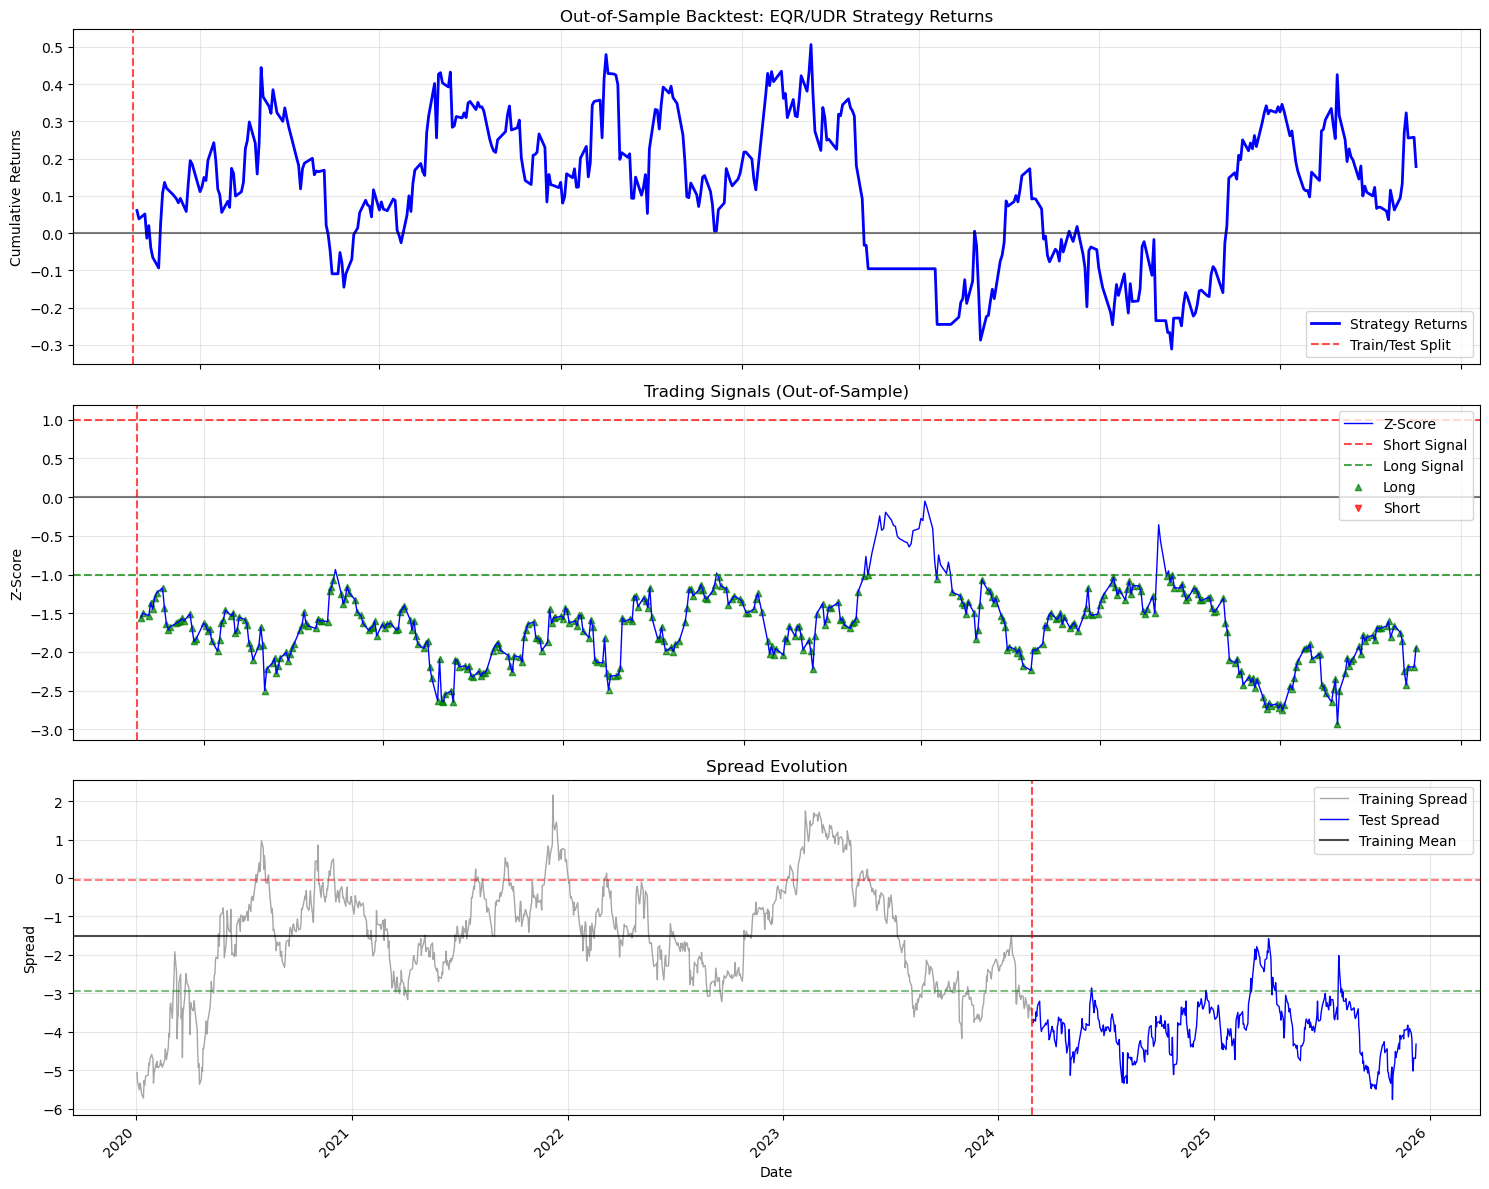


=== BACKTEST PERFORMANCE SUMMARY ===
           Metric   Value
     Total Return -41.26%
Annualized Sharpe   0.113
         Win Rate   47.7%
 Number of Trades     411
      Training R²   0.948
     Max Drawdown -81.73%


In [127]:
# Visualize backtest results
if len(consistent_pairs) > 0 and 'backtest_results' in locals():
    
    signals = backtest_results['signals']
    train_params = backtest_results['train_params']
    
    # Ensure index is datetime for proper date formatting
    if not isinstance(signals.index, pd.DatetimeIndex):
        signals.index = pd.to_datetime(signals.index)
    
    train_spread = train_params['spread'].copy()
    if not isinstance(train_spread.index, pd.DatetimeIndex):
        train_spread.index = pd.to_datetime(train_spread.index)
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Plot 1: Cumulative returns comparison
    cumulative_returns = signals.strategy_returns.cumsum()
    axes[0].plot(signals.index, cumulative_returns, linewidth=2, color='blue', label='Strategy Returns')
    axes[0].set_title(f'Out-of-Sample Backtest: {best_pair[0]}/{best_pair[1]} Strategy Returns')
    axes[0].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[0].axvline(pd.to_datetime(split_date), color='red', linestyle='--', alpha=0.7, label='Train/Test Split')
    axes[0].set_ylabel('Cumulative Returns')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Z-score and signals
    axes[1].plot(signals.index, signals.zscore, linewidth=1, color='blue', label='Z-Score')
    axes[1].axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Short Signal')
    axes[1].axhline(-1.0, color='green', linestyle='--', alpha=0.7, label='Long Signal')
    axes[1].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[1].axvline(pd.to_datetime(split_date), color='red', linestyle='--', alpha=0.7)
    
    # Mark trades
    long_trades = signals[signals.position == 1]
    short_trades = signals[signals.position == -1]
    axes[1].scatter(long_trades.index, long_trades.zscore, color='green', marker='^', s=20, alpha=0.7, label='Long')
    axes[1].scatter(short_trades.index, short_trades.zscore, color='red', marker='v', s=20, alpha=0.7, label='Short')
    
    axes[1].set_title('Trading Signals (Out-of-Sample)')
    axes[1].set_ylabel('Z-Score')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Spread evolution
    axes[2].plot(train_spread.index, train_spread, 
                linewidth=1, color='gray', alpha=0.7, label='Training Spread')
    axes[2].plot(signals.index, signals.spread, linewidth=1, color='blue', label='Test Spread')
    axes[2].axhline(train_params['spread_mean'], color='black', linestyle='-', alpha=0.7, label='Training Mean')
    axes[2].axhline(train_params['spread_mean'] + train_params['spread_std'], color='red', linestyle='--', alpha=0.5)
    axes[2].axhline(train_params['spread_mean'] - train_params['spread_std'], color='green', linestyle='--', alpha=0.5)
    axes[2].axvline(pd.to_datetime(split_date), color='red', linestyle='--', alpha=0.7)
    
    axes[2].set_title('Spread Evolution')
    axes[2].set_ylabel('Spread')
    axes[2].set_xlabel('Date')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # Fix overlapping dates
    fig.autofmt_xdate(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics table
    summary_stats = pd.DataFrame({
        'Metric': ['Total Return', 'Annualized Sharpe', 'Win Rate', 'Number of Trades', 
                  'Training R²', 'Max Drawdown'],
        'Value': [f"{backtest_results['total_return']:.2%}", 
                 f"{backtest_results['sharpe_ratio']:.3f}",
                 f"{backtest_results['win_rate']:.1%}",
                 f"{(signals.position != 0).sum()}",
                 f"{train_params['results'].rsquared:.3f}",
                 f"{(cumulative_returns - cumulative_returns.expanding().max()).min():.2%}"]
    })
    
    print("\n=== BACKTEST PERFORMANCE SUMMARY ===")
    print(summary_stats.to_string(index=False))

In [128]:
# Pairs Trading Analysis
# Selected Pair Analysis
# Setup regression and calculate spread

# Use the best pair from cointegration analysis
if len(consistent_pairs) > 0:
    best_pair = consistent_pairs[0]  # Use first consistent pair
elif len(pairs_train) > 0:
    best_pair = pairs_train[0]  # Fallback to best training pair
    print("WARNING: No consistent pairs found. Using best training pair for demonstration.")
else:
    raise ValueError("No cointegrated pairs found. Cannot proceed with analysis.")

symbol1, symbol2 = best_pair
print(f"Analyzing pair: {symbol1}/{symbol2}")

S1 = data[symbol1]  # Independent variable
S2 = data[symbol2]  # Dependent variable

# Add constant for regression
S1_const = sm.add_constant(S1)
results_pair1 = sm.OLS(S2, S1_const).fit()

# Get regression coefficient (hedge ratio)
b_pair1 = results_pair1.params[symbol1]
intercept_pair1 = results_pair1.params['const']

# Calculate spread
spread_pair1 = S2 - b_pair1 * S1

print(f"\n{symbol1}/{symbol2} Regression Results:")
print(f"Hedge Ratio (beta): {b_pair1:.4f}")
print(f"Intercept: {intercept_pair1:.4f}")
print(f"R-squared: {results_pair1.rsquared:.4f}")
print(f"Spread mean: {spread_pair1.mean():.4f}")
print(f"Spread std: {spread_pair1.std():.4f}")
print("\nRegression Summary:")
print(results_pair1.summary())

Analyzing pair: EQR/UDR

EQR/UDR Regression Results:
Hedge Ratio (beta): 0.6132
Intercept: 0.2376
R-squared: 0.9137
Spread mean: 0.2376
Spread std: 1.6481

Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                    UDR   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                 1.579e+04
Date:                Wed, 10 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:00:30   Log-Likelihood:                -2863.9
No. Observations:                1493   AIC:                             5732.
Df Residuals:                    1491   BIC:                             5742.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err  

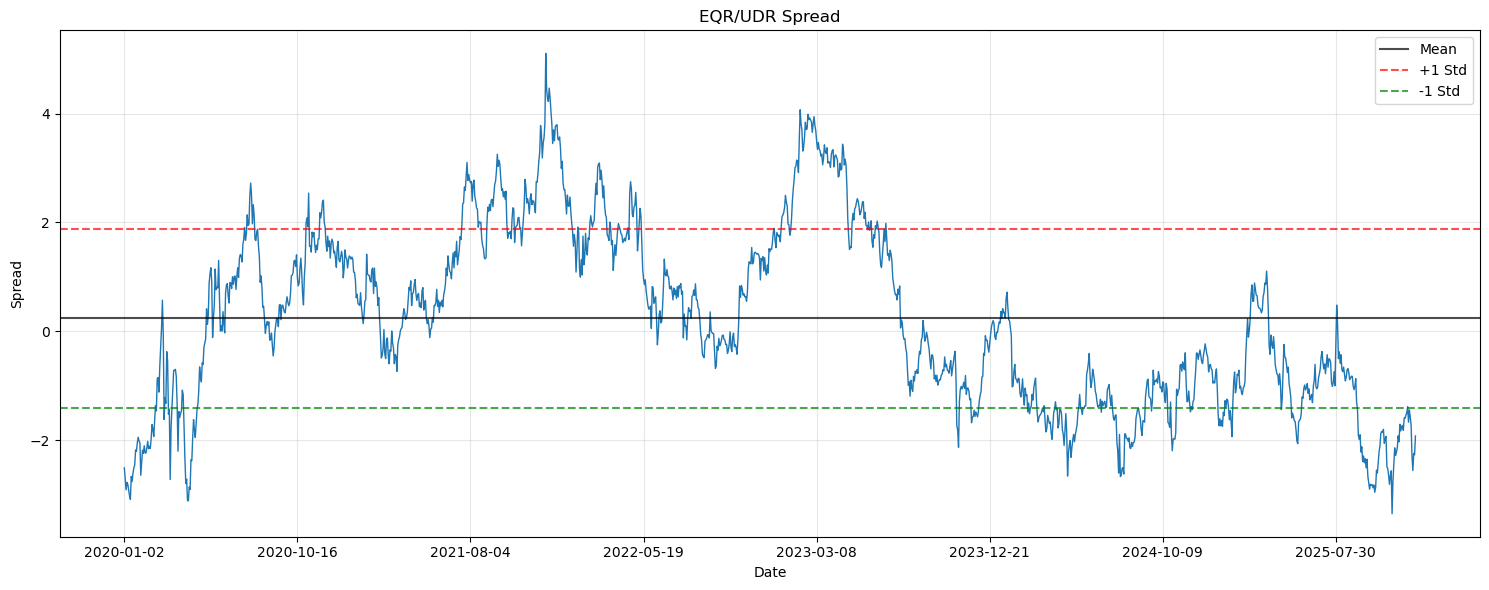

In [129]:
# Plot spread for selected pair
plt.figure(figsize=(15, 6))
spread_pair1.plot(title=f'{symbol1}/{symbol2} Spread', linewidth=1)
plt.axhline(spread_pair1.mean(), color='black', linestyle='-', alpha=0.7, label='Mean')
plt.axhline(spread_pair1.mean() + spread_pair1.std(), color='red', linestyle='--', alpha=0.7, label='+1 Std')
plt.axhline(spread_pair1.mean() - spread_pair1.std(), color='green', linestyle='--', alpha=0.7, label='-1 Std')
plt.ylabel('Spread')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

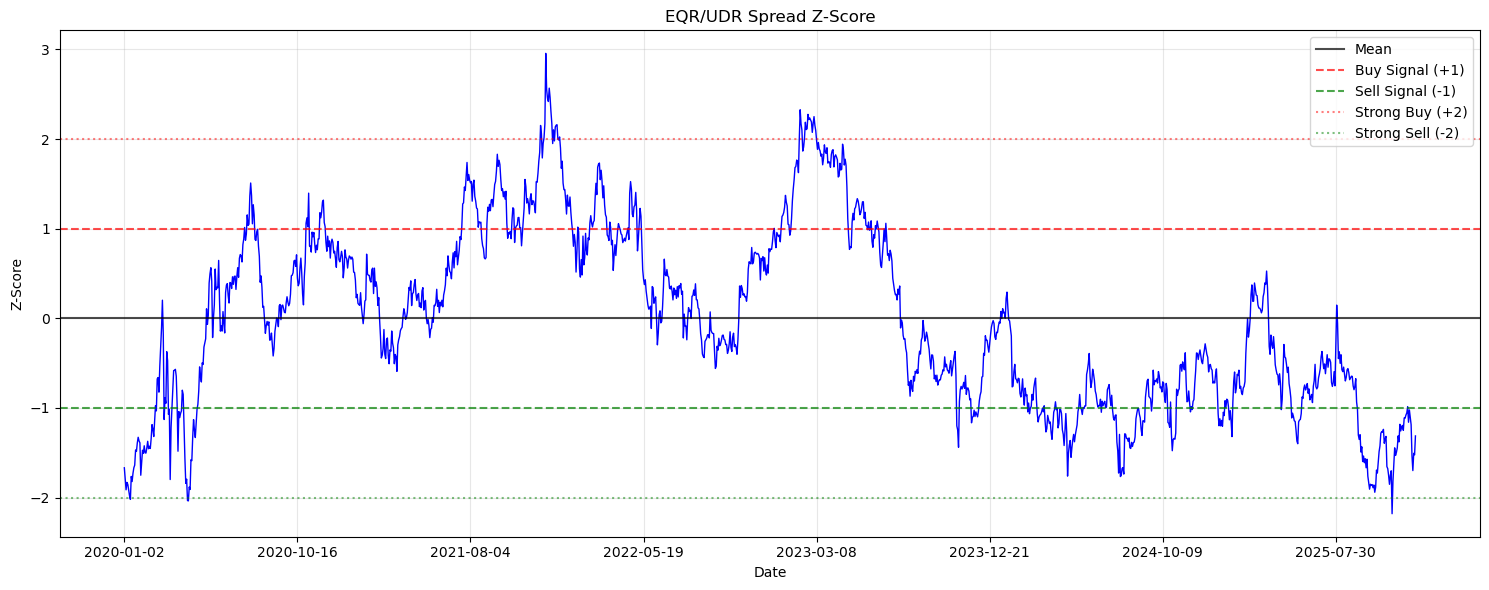

Z-score statistics for EQR/UDR:
Mean: 0.0000
Std: 1.0003
Min: -2.1803
Max: 2.9556


In [130]:
# Z-score calculation and visualization for selected pair
def zscore(series):
    return (series - series.mean()) / np.std(series)

# Calculate z-score of spread
zscore_pair1 = zscore(spread_pair1)

# Plot z-score
plt.figure(figsize=(15, 6))
zscore_pair1.plot(title=f'{symbol1}/{symbol2} Spread Z-Score', linewidth=1, color='blue')
plt.axhline(zscore_pair1.mean(), color='black', linestyle='-', alpha=0.7, label='Mean')
plt.axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Buy Signal (+1)')
plt.axhline(-1.0, color='green', linestyle='--', alpha=0.7, label='Sell Signal (-1)')
plt.axhline(2.0, color='red', linestyle=':', alpha=0.5, label='Strong Buy (+2)')
plt.axhline(-2.0, color='green', linestyle=':', alpha=0.5, label='Strong Sell (-2)')
plt.ylabel('Z-Score')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Z-score statistics for {symbol1}/{symbol2}:")
print(f"Mean: {zscore_pair1.mean():.4f}")
print(f"Std: {zscore_pair1.std():.4f}")
print(f"Min: {zscore_pair1.min():.4f}")
print(f"Max: {zscore_pair1.max():.4f}")

In [131]:
# Trading Strategy for selected pair
# Create DataFrame with signal and position
trades_pair1 = pd.DataFrame({
    'signal': zscore_pair1,
    'position': spread_pair1,
    symbol1: S1,
    symbol2: S2
})

# Add trading side based on z-score thresholds
trades_pair1['side'] = 0.0
trades_pair1.loc[trades_pair1.signal <= -1, 'side'] = 1.0   # Long spread when z-score <= -1
trades_pair1.loc[trades_pair1.signal >= 1, 'side'] = -1.0   # Short spread when z-score >= 1

# Calculate position changes and returns
trades_pair1['position_change'] = trades_pair1.position.pct_change()
trades_pair1['strategy_returns'] = trades_pair1.position_change * trades_pair1.side.shift(1)

# Remove NaN values
trades_pair1 = trades_pair1.dropna()

print(f"{symbol1}/{symbol2} Trading Signals Summary:")
print(f"Total trading signals: {(trades_pair1.side != 0).sum()}")
print(f"Long signals: {(trades_pair1.side == 1).sum()}")
print(f"Short signals: {(trades_pair1.side == -1).sum()}")
print(f"Signal ratio: {(trades_pair1.side != 0).mean():.2%}")

# Display first few trades
print("\nFirst 10 trading signals:")
signal_trades = trades_pair1[trades_pair1.side != 0].head(10)
print(signal_trades[['signal', 'side', 'strategy_returns']])

EQR/UDR Trading Signals Summary:
Total trading signals: 544
Long signals: 270
Short signals: 274
Signal ratio: 36.46%

First 10 trading signals:
              signal  side  strategy_returns
Date                                        
2020-01-03 -1.796772   1.0          0.084420
2020-01-06 -1.913743   1.0          0.070782
2020-01-07 -1.831008   1.0         -0.046756
2020-01-08 -1.852750   1.0          0.012890
2020-01-09 -1.915241   1.0          0.036575
2020-01-10 -1.979077   1.0          0.036045
2020-01-13 -2.020620   1.0          0.022641
2020-01-14 -1.764231   1.0         -0.136639
2020-01-15 -1.821629   1.0          0.035431
2020-01-16 -1.728996   1.0         -0.055224


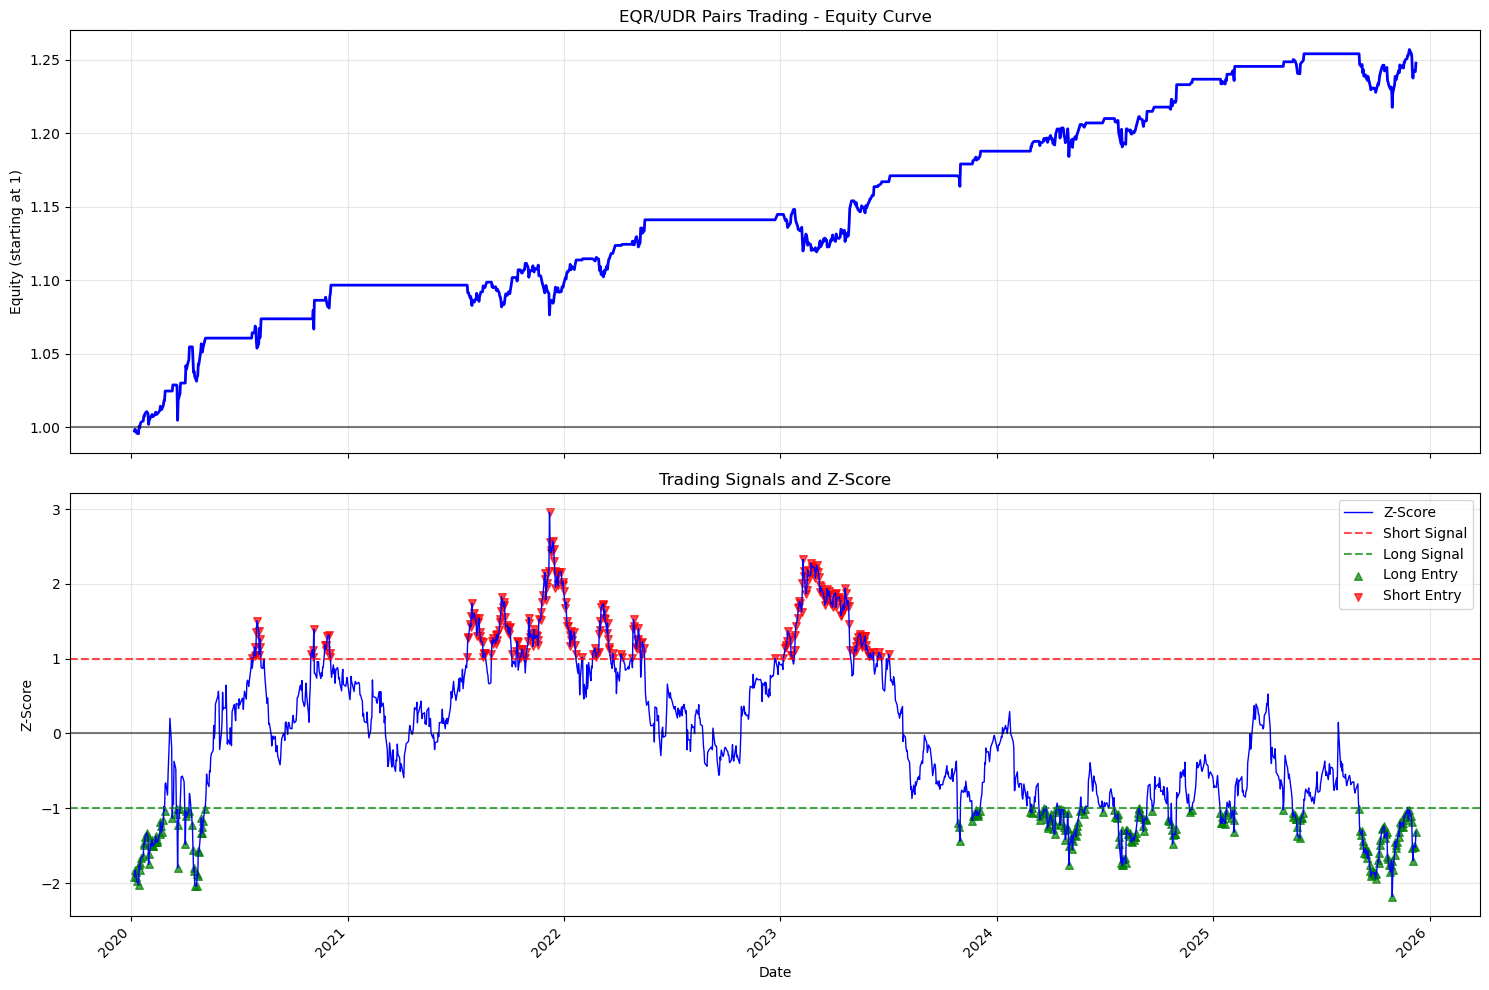


EQR/UDR Strategy Performance:
Total Return: 0.2476 (24.76%)
Annualized Sharpe Ratio: 1.1404
Maximum Drawdown: -0.0316 (-3.16%)


In [132]:
# Plot strategy performance for selected pair
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Calculate returns properly for pairs trading
# For a pairs trade: Long symbol2, Short symbol1 (when spread is expected to rise)
# Returns = weight2 * return2 - weight1 * return1
# Using equal dollar weights for simplicity

# Calculate individual stock returns
returns_S1 = S1.pct_change()
returns_S2 = S2.pct_change()

# Align with trades_pair1 index
returns_S1 = returns_S1.reindex(trades_pair1.index)
returns_S2 = returns_S2.reindex(trades_pair1.index)

# Strategy returns: when side=1 (long spread), we're long S2, short S1
# when side=-1 (short spread), we're short S2, long S1
# Use equal weights (0.5 each side)
trades_pair1['strategy_returns'] = trades_pair1.side.shift(1) * 0.5 * (returns_S2 - returns_S1)
trades_pair1 = trades_pair1.dropna()

# Ensure index is datetime for proper date formatting
if not isinstance(trades_pair1.index, pd.DatetimeIndex):
    trades_pair1.index = pd.to_datetime(trades_pair1.index)

# Plot cumulative returns using equity curve
equity_curve = (1 + trades_pair1.strategy_returns).cumprod()
axes[0].plot(trades_pair1.index, equity_curve, linewidth=2, color='blue')
axes[0].set_title(f'{symbol1}/{symbol2} Pairs Trading - Equity Curve')
axes[0].axhline(1, color='black', linestyle='-', alpha=0.5)
axes[0].set_ylabel('Equity (starting at 1)')
axes[0].grid(True, alpha=0.3)

# Plot signals with z-score
axes[1].plot(trades_pair1.index, trades_pair1.signal, linewidth=1, color='blue', label='Z-Score')
axes[1].axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Short Signal')
axes[1].axhline(-1.0, color='green', linestyle='--', alpha=0.7, label='Long Signal')
axes[1].axhline(0, color='black', linestyle='-', alpha=0.5)

# Mark actual trades
long_trades = trades_pair1[trades_pair1.side == 1]
short_trades = trades_pair1[trades_pair1.side == -1]
axes[1].scatter(long_trades.index, long_trades.signal, color='green', marker='^', s=30, alpha=0.7, label='Long Entry')
axes[1].scatter(short_trades.index, short_trades.signal, color='red', marker='v', s=30, alpha=0.7, label='Short Entry')

axes[1].set_title('Trading Signals and Z-Score')
axes[1].set_ylabel('Z-Score')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Fix overlapping dates
fig.autofmt_xdate(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Performance metrics (CORRECTED)
# Total return (compounded)
total_return = equity_curve.iloc[-1] - 1

# Sharpe ratio
sharpe_ratio = trades_pair1.strategy_returns.mean() / trades_pair1.strategy_returns.std() * np.sqrt(252)

# Max drawdown (from equity curve)
rolling_max = equity_curve.expanding().max()
drawdown = (equity_curve - rolling_max) / rolling_max
max_drawdown = drawdown.min()

print(f"\n{symbol1}/{symbol2} Strategy Performance:")
print(f"Total Return: {total_return:.4f} ({total_return*100:.2f}%)")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.4f} ({max_drawdown*100:.2f}%)")

In [133]:
# # Alternative analysis using ratio of stocks. Then apply RSI on the ratio. to confirm entries/exits
# # Function to calculate the ratio of the best_pair, symbol1/symbol2
# def calculate_ratio(data, symbol1, symbol2):
#     ratio = data[symbol1] / data[symbol2]
#     return ratio

# ratio_series = calculate_ratio(data, symbol1, symbol2)

# # Plot the ratio series
# plt.figure(figsize=(15, 6))
# ratio_series.plot(title=f'{symbol1}/{symbol2} Price Ratio', linewidth=1, color='purple')
# plt.ylabel('Price Ratio')
# plt.xlabel('Date')
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

In [134]:
# # Function to calculate RSI of the ratio series
# def calculate_rsi(series, window=3):
#     delta = series.diff()
#     gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
#     loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
#     rs = gain / loss
#     rsi = 100 - (100 / (1 + rs))
#     return rsi

# rsi_ratio = calculate_rsi(ratio_series)

# # Plot RSI of the ratio series
# plt.figure(figsize=(15, 6)) 
# rsi_ratio.plot(title=f'{symbol1}/{symbol2} Price Ratio RSI', linewidth=1, color='orange')
# plt.axhline(70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
# plt.axhline(30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
# plt.ylabel('RSI')
# plt.xlabel('Date')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()



=== BACKTESTING RSI RATIO STRATEGY: EQR/UDR ===
RSI Window: 2, Overbought: 70, Oversold: 30
Training period: 2020-01-02 to 2024-02-27
Testing period: 2024-02-28 to 2025-12-09

=== OUT-OF-SAMPLE RESULTS ===
Total Return: 0.0262 (2.62%)
Annualized Sharpe Ratio: 0.3858
Maximum Drawdown: -0.0372 (-3.72%)
Win Rate: 48.66%

Trade Distribution:
  Long Ratio (RSI < 30): 175 days
  Short Ratio (RSI > 70): 163 days
  Neutral: 109 days


=== BACKTESTING RSI RATIO STRATEGY: EQR/UDR ===
RSI Window: 2, Overbought: 80, Oversold: 20
Training period: 2020-01-02 to 2024-02-27
Testing period: 2024-02-28 to 2025-12-09

=== OUT-OF-SAMPLE RESULTS ===
Total Return: 0.0264 (2.64%)
Annualized Sharpe Ratio: 0.4345
Maximum Drawdown: -0.0378 (-3.78%)
Win Rate: 47.70%

Trade Distribution:
  Long Ratio (RSI < 20): 146 days
  Short Ratio (RSI > 80): 138 days
  Neutral: 163 days


=== BACKTESTING RSI RATIO STRATEGY: EQR/UDR ===
RSI Window: 2, Overbought: 75, Oversold: 25
Training period: 2020-01-02 to 2024-02-27
Te

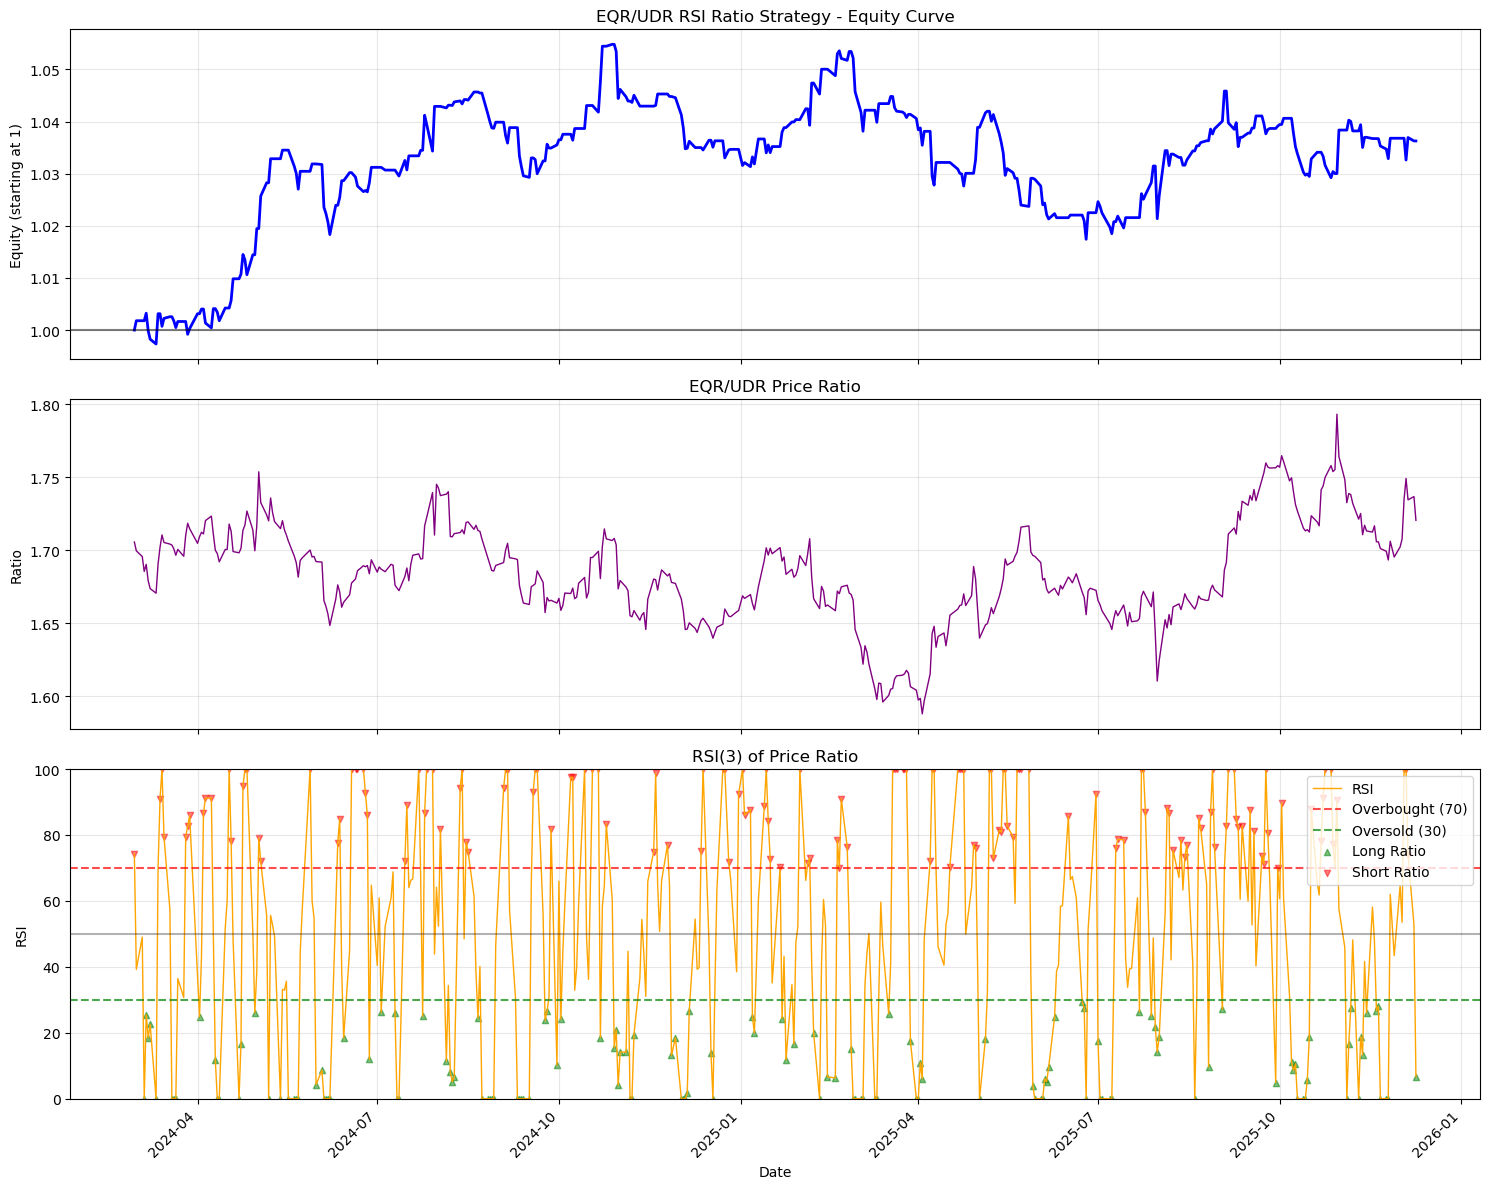


=== RSI RATIO STRATEGY SUMMARY ===
Pair: EQR/UDR
RSI Window: 3
Total Return: 3.63%
Annualized Sharpe: 0.5972
Max Drawdown: -3.55%
Win Rate: 47.90%


In [135]:
def backtest_rsi_ratio_strategy(data, symbol1, symbol2, rsi_window=3, 
                                 overbought=70, oversold=30, 
                                 train_ratio=0.7):
    """
    Backtest a pairs trading strategy using RSI on the price ratio.
    
    Strategy Logic:
    - When RSI < oversold (30): Long ratio (Long symbol1, Short symbol2)
    - When RSI > overbought (70): Short ratio (Short symbol1, Long symbol2)
    
    Parameters:
    - data: DataFrame with price data
    - symbol1, symbol2: Ticker symbols for the pair
    - rsi_window: RSI calculation period (default 3)
    - overbought: RSI level to trigger short (default 70)
    - oversold: RSI level to trigger long (default 30)
    - train_ratio: Proportion of data for training (default 0.7)
    
    Returns:
    - Dictionary with backtest results
    """
    print(f"\n=== BACKTESTING RSI RATIO STRATEGY: {symbol1}/{symbol2} ===")
    print(f"RSI Window: {rsi_window}, Overbought: {overbought}, Oversold: {oversold}")
    
    # Calculate price ratio
    ratio = data[symbol1] / data[symbol2]
    
    # Calculate RSI of the ratio
    delta = ratio.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=rsi_window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    
    # Split into train/test
    n_train = int(len(data) * train_ratio)
    split_date = data.index[n_train - 1]
    
    print(f"Training period: {data.index[0]} to {split_date}")
    print(f"Testing period: {data.index[n_train]} to {data.index[-1]}")
    
    # Create signals DataFrame (test period only for out-of-sample results)
    signals = pd.DataFrame(index=data.index[n_train:])
    signals['ratio'] = ratio.iloc[n_train:]
    signals['rsi'] = rsi.iloc[n_train:]
    signals[symbol1] = data[symbol1].iloc[n_train:]
    signals[symbol2] = data[symbol2].iloc[n_train:]
    
    # Generate trading signals
    signals['position'] = 0.0
    
    # Long ratio (long symbol1, short symbol2) when RSI oversold
    signals.loc[signals.rsi <= oversold, 'position'] = 1.0
    
    # Short ratio (short symbol1, long symbol2) when RSI overbought
    signals.loc[signals.rsi >= overbought, 'position'] = -1.0
    
    # Calculate individual stock returns
    returns_S1 = data[symbol1].pct_change().iloc[n_train:]
    returns_S2 = data[symbol2].pct_change().iloc[n_train:]
    
    # Align returns with signals
    returns_S1 = returns_S1.reindex(signals.index)
    returns_S2 = returns_S2.reindex(signals.index)
    
    # Strategy returns:
    # When position=1 (long ratio): long symbol1, short symbol2 → returns = (ret_S1 - ret_S2) / 2
    # When position=-1 (short ratio): short symbol1, long symbol2 → returns = (ret_S2 - ret_S1) / 2
    signals['strategy_returns'] = signals.position.shift(1) * 0.5 * (returns_S1 - returns_S2)
    signals = signals.dropna()
    
    # Calculate equity curve
    signals['equity_curve'] = (1 + signals.strategy_returns).cumprod()
    
    # Performance metrics
    total_return = signals.equity_curve.iloc[-1] - 1
    
    sharpe_ratio = (signals.strategy_returns.mean() / signals.strategy_returns.std() * np.sqrt(252) 
                   if signals.strategy_returns.std() != 0 else 0)
    
    # Max drawdown
    rolling_max = signals.equity_curve.expanding().max()
    drawdown = (signals.equity_curve - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    # Win rate
    winning_trades = signals[signals.strategy_returns > 0].shape[0]
    total_trades = signals[signals.strategy_returns != 0].shape[0]
    win_rate = winning_trades / total_trades if total_trades > 0 else 0
    
    # Trade statistics
    n_long = (signals.position == 1).sum()
    n_short = (signals.position == -1).sum()
    n_neutral = (signals.position == 0).sum()
    
    print(f"\n=== OUT-OF-SAMPLE RESULTS ===")
    print(f"Total Return: {total_return:.4f} ({total_return*100:.2f}%)")
    print(f"Annualized Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Maximum Drawdown: {max_drawdown:.4f} ({max_drawdown*100:.2f}%)")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"\nTrade Distribution:")
    print(f"  Long Ratio (RSI < {oversold}): {n_long} days")
    print(f"  Short Ratio (RSI > {overbought}): {n_short} days")
    print(f"  Neutral: {n_neutral} days")
    
    return {
        'signals': signals,
        'total_return': total_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'split_date': split_date,
        'rsi_window': rsi_window,
        'overbought': overbought,
        'oversold': oversold
    }


def plot_rsi_ratio_backtest(results, symbol1, symbol2):
    """
    Plot the RSI ratio strategy backtest results.
    """
    signals = results['signals']
    
    # Ensure datetime index
    if not isinstance(signals.index, pd.DatetimeIndex):
        signals.index = pd.to_datetime(signals.index)
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Plot 1: Equity Curve
    axes[0].plot(signals.index, signals.equity_curve, linewidth=2, color='blue')
    axes[0].set_title(f'{symbol1}/{symbol2} RSI Ratio Strategy - Equity Curve')
    axes[0].axhline(1, color='black', linestyle='-', alpha=0.5)
    axes[0].set_ylabel('Equity (starting at 1)')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Price Ratio
    axes[1].plot(signals.index, signals.ratio, linewidth=1, color='purple')
    axes[1].set_title(f'{symbol1}/{symbol2} Price Ratio')
    axes[1].set_ylabel('Ratio')
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: RSI with signals
    axes[2].plot(signals.index, signals.rsi, linewidth=1, color='orange', label='RSI')
    axes[2].axhline(results['overbought'], color='red', linestyle='--', alpha=0.7, 
                    label=f'Overbought ({results["overbought"]})')
    axes[2].axhline(results['oversold'], color='green', linestyle='--', alpha=0.7, 
                    label=f'Oversold ({results["oversold"]})')
    axes[2].axhline(50, color='black', linestyle='-', alpha=0.3)
    
    # Mark trade entries
    long_signals = signals[signals.position == 1]
    short_signals = signals[signals.position == -1]
    axes[2].scatter(long_signals.index, long_signals.rsi, color='green', marker='^', 
                    s=20, alpha=0.5, label='Long Ratio')
    axes[2].scatter(short_signals.index, short_signals.rsi, color='red', marker='v', 
                    s=20, alpha=0.5, label='Short Ratio')
    
    axes[2].set_title(f'RSI({results["rsi_window"]}) of Price Ratio')
    axes[2].set_ylabel('RSI')
    axes[2].set_xlabel('Date')
    axes[2].set_ylim(0, 100)
    axes[2].legend(loc='upper right')
    axes[2].grid(True, alpha=0.3)
    
    fig.autofmt_xdate(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n=== RSI RATIO STRATEGY SUMMARY ===")
    print(f"Pair: {symbol1}/{symbol2}")
    print(f"RSI Window: {results['rsi_window']}")
    print(f"Total Return: {results['total_return']:.2%}")
    print(f"Annualized Sharpe: {results['sharpe_ratio']:.4f}")
    print(f"Max Drawdown: {results['max_drawdown']:.2%}")
    print(f"Win Rate: {results['win_rate']:.2%}")


# # Run the RSI ratio backtest
# rsi_results = backtest_rsi_ratio_strategy(
#     data, symbol1, symbol2, 
#     rsi_window=3, 
#     overbought=70, 
#     oversold=30,
#     train_ratio=0.7
# )

# Test different RSI windows and thresholds
for rsi_window in [2, 3, 5]:
    for overbought, oversold in [(70, 30), (80, 20), (75, 25)]:
        print(f"\n{'='*60}")
        results = backtest_rsi_ratio_strategy(
            data, symbol1, symbol2,
            rsi_window=rsi_window,
            overbought=overbought,
            oversold=oversold,
            train_ratio=0.7
        )

# Plot results
plot_rsi_ratio_backtest(rsi_results, symbol1, symbol2)